# Activity
## (Tuesday)

### Linear Regression
- X-y split (y is the target variable, which is the total claim amount)
- Train-test split.
- Standardize the data (after the data split).
- Apply linear regression.
- Model Interpretation.

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
## Install xlrd package to load Excel files
# conda install openpyxl
## conda install xlrd

In [91]:
RAND_STATE = 34 # for reproducible shuffling
TT_RATIO = 0.3 # test/train

from scipy.stats import iqr
def remove_outliers(df):
    for c in df.columns:
            pct_75 = np.percentile(df[c], 75)
            pct_25 = np.percentile(df[c], 25)
            upper_bound = pct_75 + 1.5*iqr(df[c])
            lower_bound = pct_25 - 1.5*iqr(df[c])
            condition = (df[c] < upper_bound) & (df[c] > lower_bound)
            df[c] = df[c][condition]  # Filter out the outliers
    return df

In [92]:
dmca_df = pd.read_csv("Data/Data_Marketing_Customer_Analysis_Round3.csv")
dmca_df = dmca_df.select_dtypes(include="number")

#### plotting the correlation heatmap

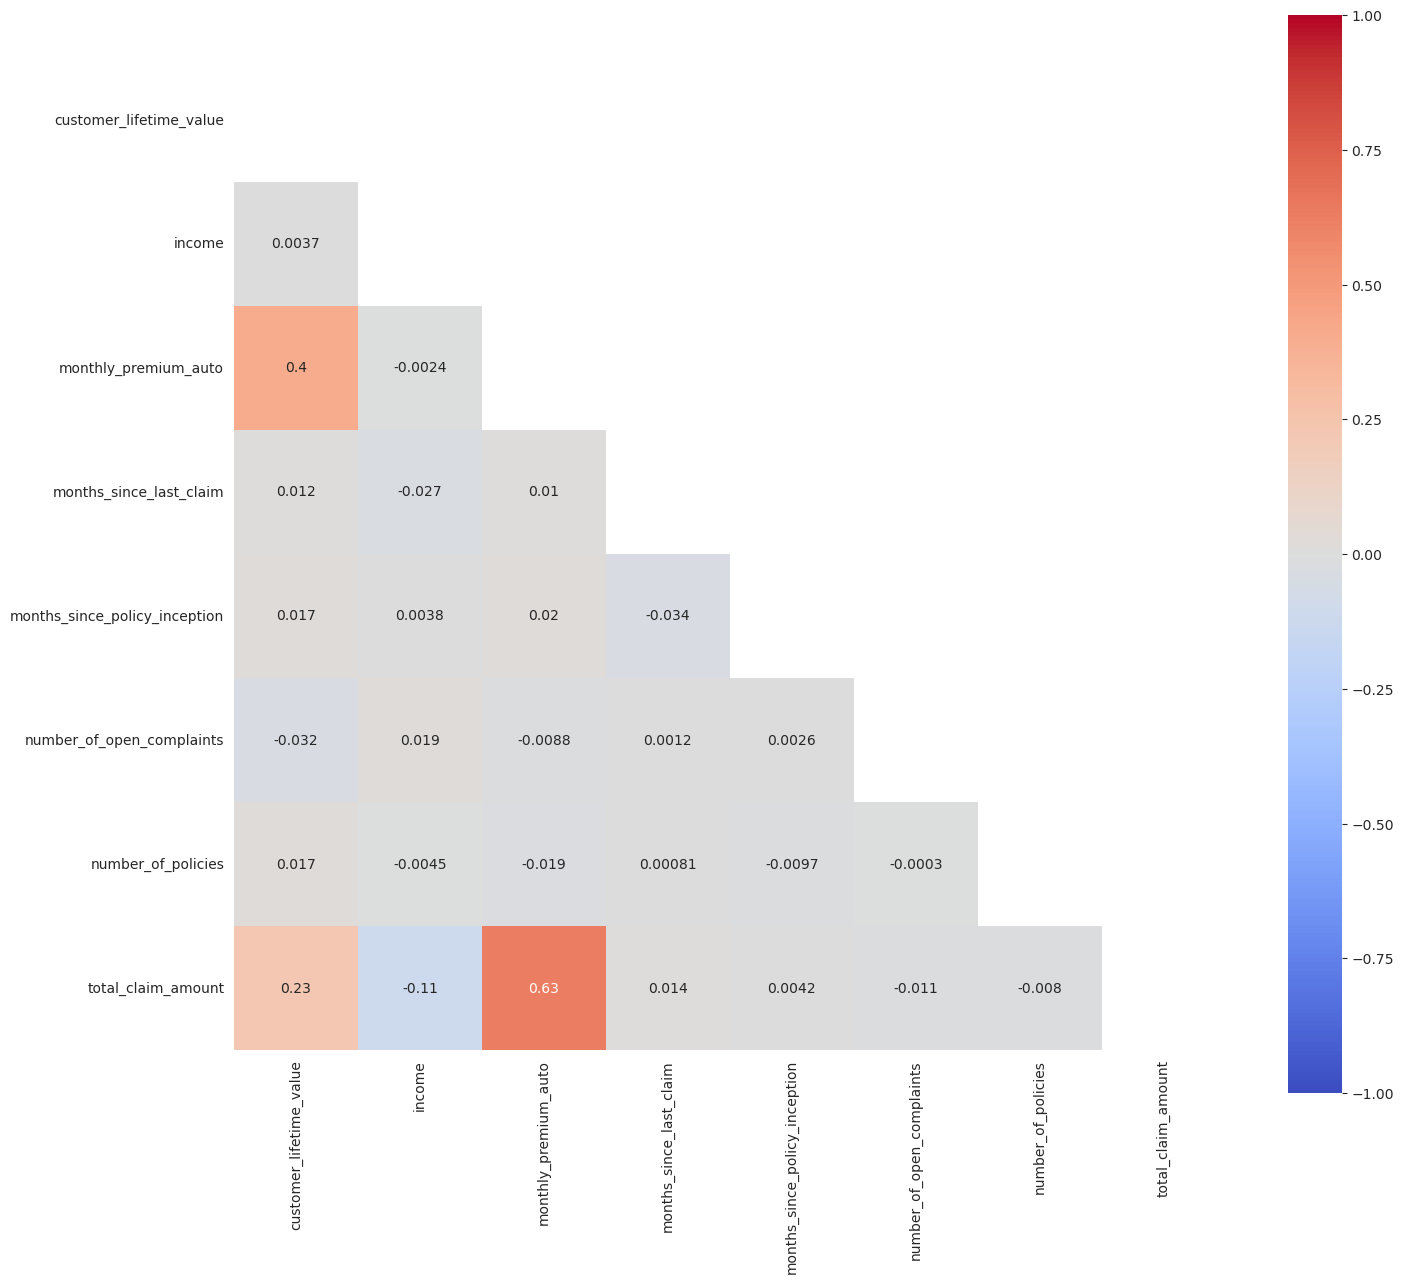

In [93]:
corr = dmca_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True # trick to filter out the upper-right triangle, which is redundant due to symmetry

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 14))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

array([[<AxesSubplot:title={'center':'customer_lifetime_value'}>,
        <AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'monthly_premium_auto'}>],
       [<AxesSubplot:title={'center':'months_since_last_claim'}>,
        <AxesSubplot:title={'center':'months_since_policy_inception'}>,
        <AxesSubplot:title={'center':'number_of_open_complaints'}>],
       [<AxesSubplot:title={'center':'number_of_policies'}>,
        <AxesSubplot:title={'center':'total_claim_amount'}>,
        <AxesSubplot:>]], dtype=object)

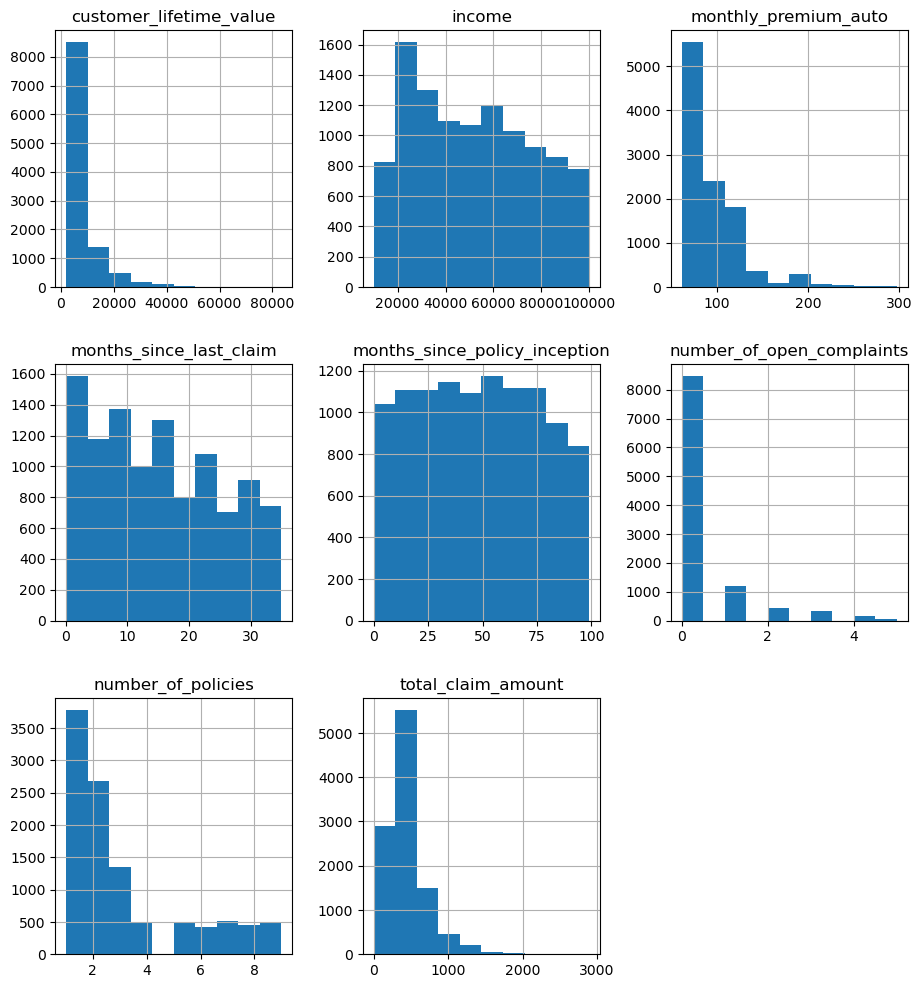

In [94]:
dmca_df.hist(figsize=(11,12))

#### removing highly correlated columns

In [95]:
CORR_THRESH = 0.80

corr_matrix=dmca_df.corr().abs()

upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))

corrd_cols = [column for column in upper_triangle.columns if any(upper_triangle[column] > CORR_THRESH)]

dmca_df.drop(corrd_cols,axis=1,inplace=True)

dmca_df.columns  #on this dataset, there are no highly correlated columns

Index(['customer_lifetime_value', 'income', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies',
       'total_claim_amount'],
      dtype='object')

## X-y split (y is the target variable, which is the total claim amount)

In [96]:
X = dmca_df.drop('total_claim_amount', axis=1)
y = dmca_df.total_claim_amount


numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(np.object)

In [97]:
# test-train split
RAND_STATE = 34 # for reproducible shuffling
TT_RATIO = 0.3 # test/train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
2705,4786,45515,61,10,33,0,9
2209,22445,80340,71,32,35,0,2
4004,6412,58776,83,20,50,2,4
1898,2254,48978,65,7,95,0,1
10016,7427,28848,96,22,54,0,7
...,...,...,...,...,...,...,...
5667,6650,44264,99,16,65,2,3
324,11124,46994,112,25,69,0,2
3157,2617,98338,65,13,33,0,1
5993,3387,23156,88,9,6,2,1


### Standardize the data (after the data split).

In [98]:
ss = StandardScaler()
numericalX_transformed = ss.fit_transform(numericalX.to_numpy().reshape(-1,1))
# sns.displot(numericalX_transformed)

In [99]:
ct = ColumnTransformer([("ss", ss, list(numericalX.columns))],
                        remainder='drop',verbose_feature_names_out=True,verbose=True).fit(X_train)
X_train_ct = pd.DataFrame(ct.transform(X_train),columns=ct.get_feature_names_out())
X_test_ct = pd.DataFrame(ct.transform(X_test),columns=ct.get_feature_names_out())

[ColumnTransformer] ............ (1 of 1) Processing ss, total=   0.0s


In [100]:
X_train = pd.DataFrame(X_train_ct)
X_test_ct

,ss__customer_lifetime_value,ss__income,ss__monthly_premium_auto,ss__months_since_last_claim,ss__months_since_policy_inception,ss__number_of_open_complaints,ss__number_of_policies
0,0.144441,-0.710041,0.576299,0.486118,-0.137927,-0.417180,2.489044
1,-0.522122,0.476639,0.517755,0.287758,0.541495,-0.417180,-0.822747
2,-0.514682,0.267135,0.488484,-0.902405,0.505736,-0.417180,-0.822747
3,-0.576345,-1.350566,-0.916569,0.982020,1.113639,0.705604,0.005201
4,2.379906,-1.204554,-0.623850,0.982020,-0.531276,-0.417180,-0.408773
...,...,...,...,...,...,...,...
3202,0.023404,0.815949,-0.740937,-1.001585,0.005109,-0.417180,-0.408773
3203,0.050301,-0.960059,-0.565306,-0.108963,-0.352481,-0.417180,-0.408773
3204,-0.125675,1.431239,-0.126227,1.477921,1.435470,-0.417180,1.247122
3205,-0.742020,0.786481,-0.565306,-0.406504,1.042121,5.196738,-0.822747


### Apply linear regression and Model Interpretation

In [101]:
X_train_const_ct = sm.add_constant(X_train_ct.to_numpy()) # adding a constant

model = sm.OLS(y_train, X_train_const_ct).fit()
predictions_train = model.predict(X_train_const_ct)

X_test_const_ct = sm.add_constant(X_test_ct) # adding a constant
predictions_test = model.predict(X_test_const_ct)

print_model = model.summary()    # checking for slope and intercept
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     753.9
Date:                Mon, 20 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:50:29   Log-Likelihood:                -51074.
No. Observations:                7482   AIC:                         1.022e+05
Df Residuals:                    7474   BIC:                         1.022e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        435.8295      2.580    168.931      0.0

In [102]:
model=LinearRegression()    # model
model.fit(X_train_ct, y_train)   # model train

LinearRegression()

# Model Validation
### Model Evaluation:
- MSE.
- RMSE.
- MAE.
- R2.
- Adjusted R2.
- Feature Importance.

### Model Iteration (Wednesday and Thursday)
- Please rerun the model after adding the hot encoded categorical variables as well as other numeric categroical variables (e.g. number of open complaintes).
- (Optional) Please rerun the model after removing the outliers and compare the results using R2 metric.

### Error metrics

In [103]:
# Making predictions

y_pred = pd.DataFrame(model.predict(X_test_ct),columns = ['total_claim_amount'] )      # model prediction

y_pred_train = pd.DataFrame(model.predict(X_train_ct),columns = ['total_claim_amount'])

In [104]:
# Mean Absolute Error
mae(y_test,y_pred)

153.89185609233462

In [105]:
# Mean Squared Error (on the test set)
mse(y_test,y_pred)

52330.379323255

In [106]:
#Root Mean Squared Error
np.sqrt(mse(y_test,y_pred))

228.758342630941

In [107]:
#prediction on the train set
mse(y_train,y_pred_train)

49747.15936894188

In [108]:
#R2
R2 = r2_score(y_test,y_pred)
print(R2)

#Adjusted R2
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print(Adj_R2)

0.39992389876814205
0.3986108219601949


In [109]:
#Feature importance, the slope of each input variable
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_.reshape(len(X_train.columns),))
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)
features_importances

,Attribute,Importance
2,ss__monthly_premium_auto,187.098365
1,ss__income,31.704366
0,ss__customer_lifetime_value,5.995983
3,ss__months_since_last_claim,2.055636
4,ss__months_since_policy_inception,0.647737
5,ss__number_of_open_complaints,0.595821
6,ss__number_of_policies,0.154904


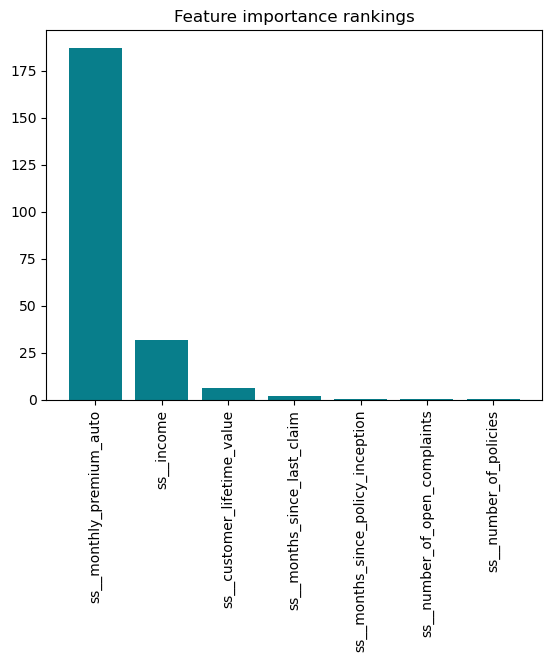

In [110]:
#Plot of feature importance
plt.bar(x=features_importances['Attribute'].iloc[:10], height=features_importances['Importance'].iloc[:10], color='#087E8B')
plt.title('Feature importance rankings', size=12)
plt.xticks(rotation='vertical')
plt.show()

# Lab | Comparing regression models

### Instructions
- Fit the models LinearRegression, Lasso and Ridge and compare the model performances.
- (Optional) Define a function that takes a list of models and trains (and tests) them so we can try a lot of them without repeating code.
- Use feature selection techniques (P-Value, RFE) to select subset of features to train the model with(if necessary).
- (Optional) Refit the models with the selected features.

In [151]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE  ## recursive feature elemination technique
from sklearn.feature_selection import VarianceThreshold # It only works with numerical features
from sklearn.linear_model import Lasso,Ridge,ElasticNet, LinearRegression


In [152]:
# Lasso regression
model_lasso=Lasso(alpha=100)    # model
model_lasso.fit(X_train_ct, y_train)   # model train
print(f"{model_lasso.__class__.__name__}: Train -> {model_lasso.score(X_train_ct, y_train)}, Test -> {model_lasso.score(X_test_ct, y_test)}")



Lasso: Train -> 0.28369606210293485, Test -> 0.2788166768658622


In [153]:
#Feature importance, the slope of each input variable (Lasso regression)
features_importances = pd.DataFrame(data={
    'Attribute': X_train_ct.columns,
    'Importance': abs(model_lasso.coef_.reshape(len(X_train_ct.columns),))
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)
features_importances

,Attribute,Importance
2,ss__monthly_premium_auto,84.601527
0,ss__customer_lifetime_value,0.000000
1,ss__income,0.000000
3,ss__months_since_last_claim,0.000000
4,ss__months_since_policy_inception,0.000000
5,ss__number_of_open_complaints,0.000000
6,ss__number_of_policies,0.000000


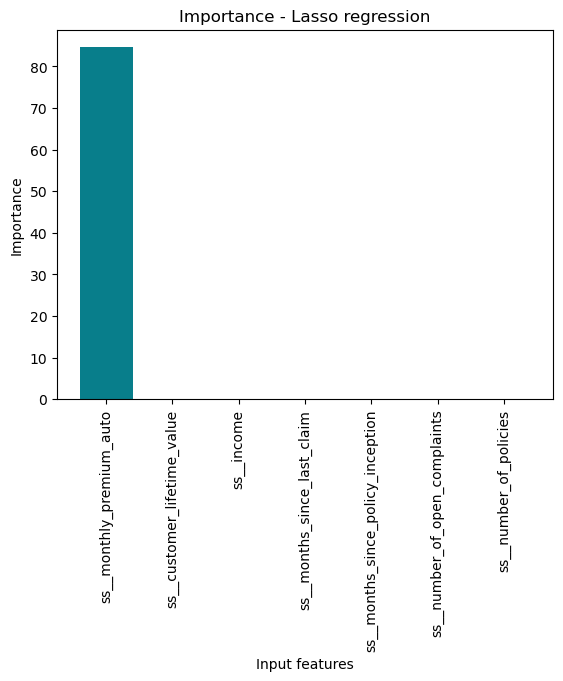

In [154]:
# Lasso regression, plotting of feature importance
plt.bar(x=features_importances['Attribute'].iloc[:], height=features_importances['Importance'].iloc[:], color='#087E8B')
plt.title('Importance - Lasso regression', size=12)
plt.xticks(rotation='vertical')
plt.xlabel("Input features")
plt.ylabel("Importance")
plt.show()

In [155]:
# Ridge regression
model_ridge=Ridge(alpha=1000000)    # model
model_ridge.fit(X_train_ct, y_train)   # model train
print(f"{model_ridge.__class__.__name__}: Train -> {model_ridge.score(X_train_ct, y_train)}, Test -> {model_ridge.score(X_test_ct, y_test)}")



Ridge: Train -> 0.006977126017885138, Test -> 0.006437598895532082


In [156]:
#Feature importance, the slope of each input variable (Ridge regression)
features_importances = pd.DataFrame(data={
    'Attribute': X_train_ct.columns,
    'Importance': abs(model_ridge.coef_.reshape(len(X_train_ct.columns),))
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)
features_importances

,Attribute,Importance
2,ss__monthly_premium_auto,1.369328
0,ss__customer_lifetime_value,0.522026
1,ss__income,0.234121
3,ss__months_since_last_claim,0.038560
6,ss__number_of_policies,0.021561
5,ss__number_of_open_complaints,0.016702
4,ss__months_since_policy_inception,0.014140


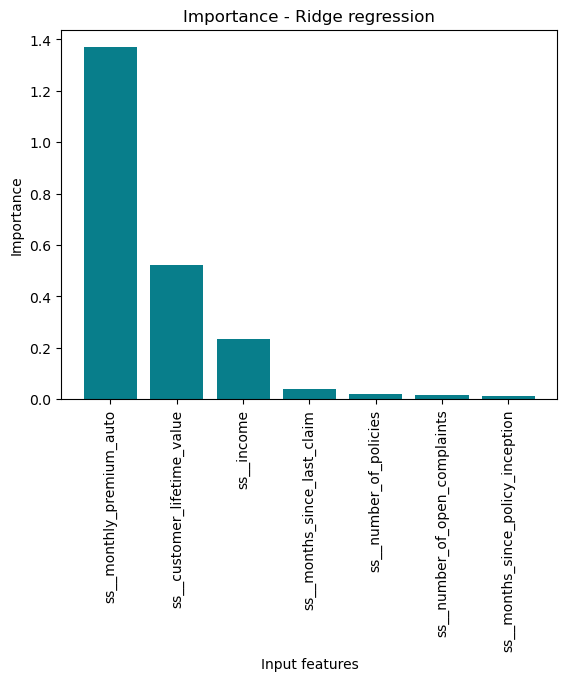

In [157]:
# Ridge regression, plotting of feature importance
plt.bar(x=features_importances['Attribute'].iloc[:], height=features_importances['Importance'].iloc[:], color='#087E8B')
plt.title('Importance - Ridge regression', size=12)
plt.xticks(rotation='vertical')
plt.xlabel("Input features")
plt.ylabel("Importance")
plt.show()

In [164]:
# Recursive feature elimination
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train = X_train.select_dtypes(include=np.number)
X_test  = X_test.select_dtypes(include=np.number)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test  = pd.DataFrame(X_test, columns=X.columns)

#X_train.isna().sum()
nulls = pd.DataFrame(X_train.isna().sum()).reset_index()
#nulls.head()
nulls.columns = ['Column','nas']
#nulls.head()
#nulls[nulls['nas'] > 0].head()
cols_to_drop = nulls[nulls['nas'] > 0]['Column'] # Too drastic, but made on pourpose for quick filtering (don't do this in production!!)

X_train.drop(columns=cols_to_drop, axis=1, inplace = True)
X_test.drop(columns=cols_to_drop, axis=1, inplace = True)

#display(X_train)

lm = LinearRegression()

selector = RFE(lm, n_features_to_select = 3, step = 1, verbose = 1) # Step is how many features to add or drop everytime
selector.fit(X_train, y_train)

kept_features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
kept_features = list(X_train.iloc[:,kept_features].columns)

X_train = selector.transform(X_train)
X_test  = selector.transform(X_test)

X_train = pd.DataFrame(X_train, columns=kept_features)
X_test  = pd.DataFrame(X_test, columns=kept_features)

print("Final selected features: ")
display(X_train)



Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Final selected features: 


,monthly_premium_auto,months_since_last_claim,number_of_policies
0,65,9,2
1,106,5,6
2,101,3,1
3,63,3,2
4,115,1,2
...,...,...,...
8546,94,22,3
8547,98,17,2
8548,64,26,8
8549,106,23,2
